(1800,)


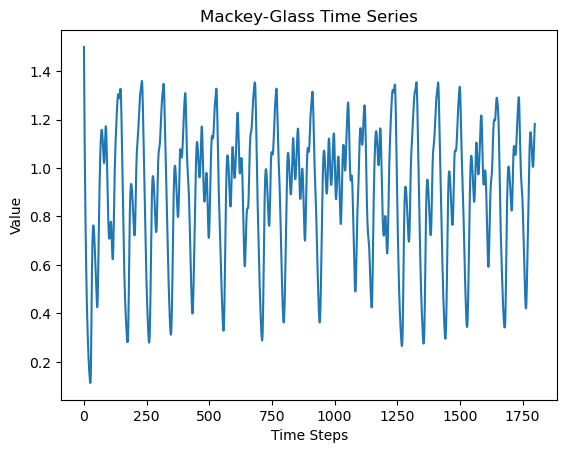

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def mackey_glass(length=1800, beta=0.2, gamma=0.1, n=10, tau=25,  initial_value=1.5):
    x = np.zeros(length)
    x[0] = initial_value
    for t in range(1, length):
        if(t-tau <0):
            x[t] = x[t-1]  - gamma * x[t-1]
        else:
            x[t] = x[t-1] + (beta * x[t-tau] / (1 + x[t-tau]**n) - gamma * x[t-1])
    return x

time_series = mackey_glass()
print(time_series.shape)
plt.plot(time_series)
plt.title("Mackey-Glass Time Series")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.show()


In [10]:
inputs = []
outputs = []

minus_list = [0,5,15,10,20]


for t in range(300, 1500):
    inputs.append([time_series[t-minus] for minus in minus_list])  
    outputs.append(time_series[t + 5])

inputs = np.array(inputs).reshape(5,len(inputs))
outputs = np.array(outputs).reshape(1,len(outputs))
print("Inputs Shape:", inputs.shape)  # (5, N)
print("Outputs Shape:", outputs.shape)  # (1, N)


Inputs Shape: (5, 1200)
Outputs Shape: (1, 1200)


In [11]:
train_split = 0.7
val_split = 0.15

num_samples = inputs.shape[1]
train_end = int(num_samples * train_split)
val_end = int(num_samples * (train_split + val_split))

X_train, y_train = inputs[:, :train_end], outputs[:, :train_end]
X_val, y_val = inputs[:, train_end:val_end], outputs[:, train_end:val_end]
X_test, y_test = inputs[:, val_end:], outputs[:, val_end:]

print("Train Samples:", X_train.shape[1])
print("Validation Samples:", X_val.shape[1])
print("Test Samples:", X_test.shape[1])

Train Samples: 840
Validation Samples: 180
Test Samples: 180


In [12]:
# Define MLP model

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers):
        super(MLP, self).__init__()
        layers = []
        in_features = input_size
        for hidden_units in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_units))
            layers.append(nn.Sigmoid())
            in_features = hidden_units
        layers.append(nn.Linear(in_features, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

def train_and_evaluate(train, val, test, layer_configurations, early_stopping = True, weight_decay = 0.0):
    train_inputs = torch.tensor(train[0], dtype=torch.float32)
    train_outputs = torch.tensor(train[1], dtype=torch.float32).view(-1, 1)
    val_inputs = torch.tensor(val[0], dtype=torch.float32)
    val_outputs = torch.tensor(val[1], dtype=torch.float32).view(-1, 1)
    test_inputs = torch.tensor(test[0], dtype=torch.float32)
    test_outputs = torch.tensor(test[1], dtype=torch.float32).view(-1, 1)

    best_config = None
    worst_config = None
    best_val_error = float('inf')
    worst_val_error = float('-inf')

    val_errors = []
    test_errors = []

    # Grid search
    for config in layer_configurations:
        nh1, nh2 = config
        model = MLP(input_size=train_inputs.shape[0], hidden_layers=[nh1, nh2])
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay) 

        best_val_loss = float('inf')
        patience = 10
        trigger_times = 0

        for epoch in range(1000):
            model.train()
            optimizer.zero_grad(set_to_none=True)
            outputs = model(train_inputs.T)
            loss = criterion(outputs, train_outputs)
            loss.backward()
            optimizer.step()
            model.eval()
            
            with torch.no_grad():
                val_outputs_pred = model(val_inputs.T)
                val_loss = criterion(val_outputs_pred, val_outputs)
                
            if early_stopping:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    trigger_times = 0
                else:
                    trigger_times += 1

                if trigger_times >= patience:
                    print(trigger_times, epoch)
                    break

        val_error = best_val_loss.item()
        val_errors.append((config, val_error))

        # Evaluate model on test
        with torch.no_grad():
            test_outputs_pred = model(test_inputs.T)
            test_error = mean_squared_error(test_outputs.numpy(), test_outputs_pred.numpy())
            test_errors.append((config, test_error))

        # Update best and worst configs
        if val_error < best_val_error:
            best_val_error = val_error
            best_config = config
        if val_error > worst_val_error:
            worst_val_error = val_error
            worst_config = config

    print(f"Best configuration: {best_config} with validation error: {best_val_error}")
    print(f"Worst configuration: {worst_config} with validation error: {worst_val_error}")

    # Plot validation and test errors for each config
    
    configs, val_errs = zip(*val_errors)
    _, test_errs = zip(*test_errors)
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(configs)), val_errs, marker='o', label='Validation Error')
    plt.plot(range(len(configs)), test_errs, marker='x', label='Test Error')
    plt.xticks(range(len(configs)), configs, rotation=45)
    plt.xlabel('Layer Configurations (nh1, nh2)')
    plt.ylabel('Error')
    plt.title('Validation and Test Errors for Different Layer Configurations')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate best and worst models on the test set
    best_model = MLP(input_size=train_inputs.shape[0], hidden_layers=best_config)
    best_model.eval()
    with torch.no_grad():
        test_outputs_pred = best_model(test_inputs.T)
        test_error = mean_squared_error(test_outputs.numpy(), test_outputs_pred.numpy())
    print(f"Test error for the best configuration: {test_error}")
    
    worst_model = MLP(input_size=train_inputs.shape[0], hidden_layers=worst_config)
    worst_model.eval()
    with torch.no_grad():
        test_outputs_pred = worst_model(test_inputs.T)
        test_error = mean_squared_error(test_outputs.numpy(), test_outputs_pred.numpy())
    print(f"Test error for the worst configuration: {test_error}")
    
    return best_config, worst_config, best_model, worst_model

10 595
10 28
10 761
10 338
10 352
10 265
10 608
10 227
Best configuration: (5, 4) with validation error: 0.0861583948135376
Worst configuration: (3, 2) with validation error: 0.21087642014026642


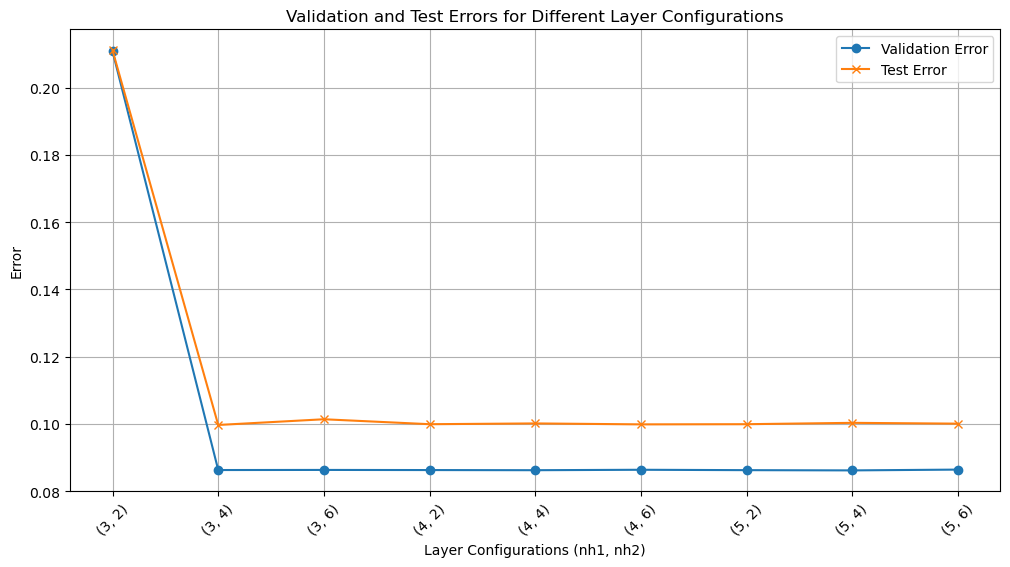

Test error for the best configuration: 0.94291752576828
Test error for the worst configuration: 0.6289601922035217
Best model config: (5, 4)
Worst model config: (3, 2)


In [13]:
train_data = (X_train, y_train)
val_data = (X_val, y_val)
test_data = (X_test, y_test)
layer_configs = [(i, y) for i in [3, 4, 5] for y in [2, 4, 6]]

best_model, worst_model, val_results, test_results = train_and_evaluate(train_data, val_data, test_data, layer_configs)
print("Best model config:", best_model)
print("Worst model config:", worst_model)

In [14]:
num_trials = 10

def evaluate_robustness(config, train, test):
    test_errors = []
    for trial in range(num_trials):
        torch.manual_seed(trial)
        model = MLP(input_size=train[0].shape[0], hidden_layers=config)
        model.eval()
        with torch.no_grad():
            test_inputs = torch.tensor(test[0], dtype=torch.float32)
            test_outputs = torch.tensor(test[1], dtype=torch.float32).view(-1, 1)
            
            test_outputs_pred = model(test_inputs.T)
            test_error = mean_squared_error(test_outputs.numpy(), test_outputs_pred.numpy())
            test_errors.append(test_error)
    
    test_errors = np.array(test_errors)
    mean_error = np.mean(test_errors)
    std_error = np.std(test_errors)
    return mean_error, std_error

best_mean, best_std = evaluate_robustness(best_model, train_data, test_data)
worst_mean, worst_std = evaluate_robustness(worst_model, train_data, test_data)

print(f"Best Model: Mean Test Error = {best_mean:.4f}, Std= {best_std:.4f}")
print(f"Worst Model: Mean Test Error = {worst_mean:.4f}, Std= {worst_std:.4f}")


Best Model: Mean Test Error = 1.2201, Std= 0.8285
Worst Model: Mean Test Error = 1.2699, Std= 0.8854
